In [1]:
%load_ext autoreload
%autoreload 2
import os
import random
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sns
import sys
sys.path.append('../../')
from dataset import Dataset, SpikingDataset, RegSpikingDataset
from torch.utils.data.dataloader import DataLoader
from Loss import KDLoss
import torch
import torch.nn as nn
import torchvision
random.seed(1338)
import scipy.io
import numpy as np
import matplotlib.pyplot as plt
import copy
from pyESN import ESN
from scipy import interpolate
from gen_data import *
from tanh import tanh
%load_ext autoreload

%autoreload 2

torch.__version__
# The coarse network structure is dicated by the Fashion MNIST dataset. 
dtype = torch.float

# Check whether a GPU is available
if torch.cuda.is_available():
    device = torch.device('cuda:1')
    #device = torch.device("cuda")     
else:
    device = torch.device("cpu")
tau_mem = 10e-3
tau_syn = 5e-3
time_step = 1e-3
alpha   = float(np.exp(-time_step/tau_syn))
beta    = float(np.exp(-time_step/tau_mem))

weight_scale = 7*(1.0-beta) # this should give us some spikes to begin with

print("init done")


def ber(a, b, fft_size=64):
    def qpsk_demod(a):
        a_real = np.real(a)
        a_imag = np.imag(a)

        a_real_bit = np.ones(a_real.shape)
        a_real_bit[a_real < 0] = 0

        a_imag_bit = np.ones(a_imag.shape)
        a_imag_bit[a_imag < 0] = 0

        a_bit = np.concatenate((a_imag_bit, a_real_bit), axis=0)
        a_bit = a_bit.reshape((1, -1), order='F')
        return a_bit
    
    carrier = np.hstack((np.arange(-26, -21), np.arange(-20, -7), np.arange(-6, 0),
                         np.arange(1, 7), np.arange(8, 21), np.arange(22, 27))) + fft_size // 2
    
    assert a.shape == b.shape
    a_list = a[:, carrier].reshape((1, -1))
    b_list = b[:, carrier].reshape((1, -1))

    a_bits = self.qpsk_demod(a_list)
    b_bits = self.qpsk_demod(b_list)

    error_count = np.sum(a_bits != b_bits)
    total_bits = a_bits.shape[1]
        
    ber = float(error_count) / float(total_bits)
    return ber

def GetDataset(dataset_path):
    data = scipy.io.loadmat(dataset_path)
    raw_data = np.squeeze(data['receivedSig'])
    target = np.squeeze(data['target'])
    x_train = raw_data[:1000]
    y_train = target[:1000]
    x_test = raw_data[1000:]
    y_test = target[1000:]
    x_train = np.reshape(x_train, (len(x_train)))
    x_test = np.reshape(x_test, (len(x_test)))
    return x_train, y_train, x_test, y_test

class SurrGradSpike(torch.autograd.Function):
    """
    Here we implement our spiking nonlinearity which also implements 
    the surrogate gradient. By subclassing torch.autograd.Function, 
    we will be able to use all of PyTorch's autograd functionality.
    Here we use the normalized negative part of a fast sigmoid 
    as this was done in Zenke & Ganguli (2018).
    """
    
    scale = 100.0 # controls steepness of surrogate gradient

    @staticmethod
    def forward(ctx, input):
        """
        In the forward pass we compute a step function of the input Tensor
        and return it. ctx is a context object that we use to stash information which 
        we need to later backpropagate our error signals. To achieve this we use the 
        ctx.save_for_backward method.
        """
        ctx.save_for_backward(input)
        out = torch.zeros_like(input)
        out[input > 0] = 1.0
        return out

    @staticmethod
    def backward(ctx, grad_output):
        """
        In the backward pass we receive a Tensor we need to compute the 
        surrogate gradient of the loss with respect to the input. 
        Here we use the normalized negative part of a fast sigmoid 
        as this was done in Zenke & Ganguli (2018).
        """
        input, = ctx.saved_tensors
        grad_input = grad_output.clone()
        grad = grad_input/(SurrGradSpike.scale*torch.abs(input)+1.0)**2
        return grad
    
# here we overwrite our naive spike function by the "SurrGradSpike" nonlinearity which implements a surrogate gradient
spike_fn  = SurrGradSpike.apply

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
init done


In [2]:
silent = True
method = 'RLS'  # RLS; INV; INV+RLS
# N_total_frame = 17
N_total_frame = 94
N_sync_frame = 4
# SNR_list = np.arange(1,20,2)
SNR_list = [1000]

# Dataset selection
folder_name = 'data/S2/'  # LOS_Near:S2, LOS_Far:S3, NLOS:S1
output_folder = 'data_outputs/S2'

if folder_name == 'data/S1/':  # NLOS
    delay = 0
    packet_num = 21
elif folder_name == 'data/S2/':  # LOS_Near
    delay = 1
    packet_num = 27 # correct
elif folder_name == 'data/S3/':  # LOS_Far
    delay = 1
    packet_num = 22 # 23c
else:
    print("Undefined Dataset")
    exit(1)
    
window_size = 2
N_reservoir = 16
debug = False

ber_record = []
dfe_ber_record = []
LS_ber_record = []
comb_ber_record = []
sta_ber_record = []
tanh_lut = tanh(
    input_bit=8,
    dx_bit=8,
    slope_fmt=(10, 10),
    intercept_fmt=(19, 19),
    max=8,
    better_lut=True,
    verbose=False,
    plot=False)

SNR = SNR_list[0]
i = 1
rc = RC(silent, method, N_total_frame, N_sync_frame, SNR, delay, window_size, i,
        N_reservoir=16,
        spectral_radius=0.2,
        sparsity=0.4,
        noise=1e-6,
        lut_activation=False,  # True,
        tanh_lut=tanh_lut,
        input_scale=25,  #40, #50, # 25,
        reservoir_input_scale = 8,  #4,  #5,
        show_wout=False,
        output_folder= output_folder,
        debug=debug,
        use_fpga= None,
        sock= None,  # usock
        addr = None) # addr

train_input, train_label, test_input, test_label = rc.run()

In [3]:
#def ProcessLabel(label):
#    min_val, max_val = np.min(label), np.max(label)
#    label -= min_val
#    return label
#print(np.min(train_label))
#train_label = ProcessLabel(train_label)

In [4]:
print(train_label)

[[ 0.          0.        ]
 [ 0.36799005  0.36799005]
 [-1.05954977  0.01871674]
 ...
 [-0.11784918 -0.02450429]
 [ 0.04877258 -0.2078674 ]
 [ 0.19325261  0.22048032]]


In [7]:
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F

def Recurrent(h1, nb_hidden, nb_steps):
    batch_size = h1.shape[0]
    syn = torch.zeros((batch_size, nb_hidden), device=h1.device)
    mem = torch.zeros((batch_size, nb_hidden), device=h1.device)
    mem_rec = [mem]
    spk_rec = [mem]

    # Compute hidden layer activity
    for t in range(nb_steps):
        mthr = mem-1.0
        out = spike_fn(mthr)
        rst = torch.zeros_like(mem)
        c   = (mthr > 0)
        rst[c] = torch.ones_like(mem)[c]

        new_syn = alpha*syn +h1[:,t]
        new_mem = beta*mem +syn -rst

        mem = new_mem
        syn = new_syn

        mem_rec.append(mem)
        spk_rec.append(out)

    mem_rec = torch.stack(mem_rec,dim=1)
    spk_rec = torch.stack(spk_rec,dim=1)
    return spk_rec

def Readout(h2, nb_outputs):
    # Readout layer
    batch_size = h2.shape[0]
    flt = torch.zeros((batch_size,nb_outputs), device=h2.device)
    out = torch.zeros((batch_size,nb_outputs), device=h2.device)
    out_rec = [out]
    for t in range(nb_steps):
        new_flt = alpha*flt +h2[:,t]
        new_out = beta*out +flt

        flt = new_flt
        out = new_out

        out_rec.append(out)

    out_rec = torch.stack(out_rec,dim=1)
    #other_recs = [mem_rec, spk_rec]
    return out_rec  #, other_recs

class SpikingDenseNet(nn.Module):
    def __init__(self, input_size, nb_steps):
        super(SpikingDenseNet, self).__init__()
        self.fc1 = nn.Linear(input_size, 96, bias=False)
        self.fc2 = nn.Linear(96, 96, bias=False)
        self.fc3 = nn.Linear(96, 2, bias=False)
        self.num_h1 = 96
        self.num_h2 = 96
        self.num_output = 2
        self.nb_steps = nb_steps
        

    def forward(self, x):
        x = torch.flatten(x, start_dim=2)
        x = self.fc1(x)
        x = Recurrent(x, self.num_h1, self.nb_steps)
        x = self.fc2(x)
        x = Recurrent(x, self.num_h2, self.nb_steps)
        x = self.fc3(x)
        x = Readout(x, self.num_output)
        return x
    
class DenseNet(nn.Module):
    def __init__(self, input_size):
        super(DenseNet, self).__init__()
        n_nodes = 256
        self.fc1 = nn.Linear(input_size, n_nodes, bias=False)
        self.fc2 = nn.Linear(n_nodes, n_nodes, bias=False)
        self.fc3 = nn.Linear(n_nodes, 2, bias=False)
        self.act = torch.nn.ReLU(inplace=False)

    def forward(self, x):
        x = x.flatten(start_dim=1)
        print(x.shape)
        x = self.fc1(x)
        x = self.act(x)
        x = self.fc2(x)
        x = self.act(x)
        x = self.fc3(x)
        return x


In [8]:
def DNNTrain(trainloader, testloader, net, lr=1e-3, epochs=10):
    optimizer = torch.optim.Adam(net.parameters(), lr=lr, weight_decay=1e-4)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)
    criterion = torch.nn.CrossEntropyLoss()
    
    for epoch in range(epochs):
        running_loss = 0.0
        for idx, data in enumerate(trainloader):
            x, y = data
            print(x.shape)
            x = x.float().to(device)
            y = y.float().to(device)
            optimizer.zero_grad()
            output = net(x)
            loss = criterion(output, y.long())
            running_loss = loss.item()
            loss.backward()
            optimizer.step()
        scheduler.step()
        
def Eval(testloader, net):
    net.eval()
    total, correct = 0, 0
    with torch.no_grad():
        for data in testloader:
            x, y = data
            x = x.float().to(device)
            pred = torch.argmax(net(x), axis=1).cpu()
            total += x.shape[0]
            correct += (pred == y).float().sum()
    print("accuracy, ", correct / total)


def train(trainloader, testloader, model, lr=2e-3, nb_epochs=10):
    #params = [w1,w2]
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, betas=(0.9,0.999))
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)
    loss_fn = torch.nn.MSELoss()
    
    loss_hist = []
    for e in range(nb_epochs):
        print(e)
        local_loss = []
        for x_local, y_local in trainloader:
            x_local = x_local.float().to(device)
            y_local = y_local.float().to(device)
    
            output = model(x_local)
            m, _ = torch.max(output,1)
            loss_val = loss_fn(m, y_local)
            
            optimizer.zero_grad()
            loss_val.backward()
            optimizer.step()
            local_loss.append(loss_val.item())
            
        
        #if e % 1 == 30 and e != 0:
        #    print("Training accuracy: %.3f"%(compute_ber(trainloader, net, "train")))
        #    print("Test accuracy: %.3f"%(compute_ber(testloader, net, name)))
        scheduler.step()
        mean_loss = np.mean(local_loss)
        print(mean_loss)
        #print("Epoch %i: loss=%.5f"%(e+1,mean_loss))
        loss_hist.append(mean_loss)
        
    return loss_hist
        
def Extract(x, y, res, label):
    x = x.cpu().numpy()
    y = y.cpu().numpy()
    batch_size, time_step, inputs = x.shape
    for i in range(batch_size):
        idx1 = np.nonzero(x[i, :, 0])[0]
        idx2 = np.nonzero(x[i, :, 1])[0]
        res[0].append(idx1)
        res[1].append(idx2)
        label.append(y[i])
    
def compute_ber(dataloader, model, name):
    """ Computes classification accuracy on supplied data in batches. """
    res = 0.0
    cnt = 0
    for x_local, y_local in dataloader:
        x_local = x_local.float().to(device)
        y_local = y_local.float().to(device)
        
        output = model(x_local)
        m, _ = torch.max(output, 1) # max over time

        res += ber(m, y_local)
        cnt += 1
    
    return res / cnt

In [14]:
print(train_input.shape, train_label.shape)

(7521, 4) (7521, 2)


In [17]:
nb_inputs  = 2
nb_hidden  = 96
nb_outputs = 2

time_step = 1e-3
nb_steps  = 100

batch_size = 32
device = torch.device("cpu")

import scipy.io

net = SpikingDenseNet(input_size=nb_inputs * 4, nb_steps=nb_steps).float().to(device)

    
train_data = RegSpikingDataset(train_input, train_label, nb_inputs, nb_steps)
test_data = RegSpikingDataset(train_input, train_label, nb_inputs, nb_steps)
trainloader = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=8)
testloader = DataLoader(test_data, batch_size=batch_size, shuffle=True, num_workers=8)

lr = 1e-3
name = "test_symbol_detection"
loss_hist = train(trainloader, testloader, net, lr=lr, nb_epochs=10)


0
1.5494992210198257
1
0.9218023778018305
2
0.910081330497386
3
0.2124315969393415
4
0.12860032407787897
5
0.12130350532341685
6
0.11119103962081973
7
0.10670115645596032
8
0.10429761399341336
9
0.09941013500299621


In [18]:
for x_local, y_local in trainloader:
    x_local = x_local.float().to(device)
    y_local = y_local.float().to(device)
    
    output = net(x_local)
    m, _ = torch.max(output,1)
    print(m)
    print(y_local)
    

tensor([[1.3236, 1.1247],
        [1.5505, 1.2363],
        [1.7634, 1.2174],
        [1.7902, 1.6432],
        [1.7732, 1.4602],
        [1.4932, 1.3483],
        [1.6727, 1.5107],
        [1.2309, 1.4567],
        [1.1002, 1.1706],
        [1.3730, 1.0463],
        [1.1202, 1.2638],
        [1.4644, 1.4047],
        [1.7047, 1.4698],
        [1.3191, 1.1996],
        [1.2887, 1.0537],
        [1.1657, 1.0004],
        [1.4653, 1.0295],
        [1.2405, 1.3925],
        [1.5187, 1.2386],
        [1.4495, 1.0529],
        [1.5214, 1.7379],
        [1.3441, 1.6139],
        [1.1697, 1.1755],
        [0.7734, 0.8344],
        [1.2295, 0.8369],
        [1.4117, 1.1919],
        [1.9649, 1.8690],
        [1.3780, 1.1599],
        [1.4243, 1.1529],
        [1.4823, 1.3254],
        [1.0240, 0.9456],
        [1.4316, 1.1270]], grad_fn=<MaxBackward0>)
tensor([[1.4785, 1.0648],
        [1.2853, 1.5353],
        [1.0460, 1.0920],
        [1.0460, 1.0920],
        [1.5057, 1.5341],
        [1.05

In [19]:
print(net.fc1.weight.data.shape)
print(net.fc2.weight.data.shape)
print(net.fc3.weight.data.shape)
with open('weight.npy', 'wb') as f:
    np.save(f, net.fc1.weight.data.numpy())
    np.save(f, net.fc2.weight.data.numpy())
    np.save(f, net.fc3.weight.data.numpy())

torch.Size([96, 8])
torch.Size([96, 96])
torch.Size([2, 96])


5dB 
4Tx: Train: 98.8%,  test: 97.1%
6Tx: Train: 99.8%.  test: 99.6%

20dB
4Tx: Train: 70.3%,  test: 65.3%
6Tx: Train: 80.9%.  test: 75.6%

25dB
4Tx: Train: 67.8%,  test: 52.2%
6Tx: Train: 53.9%.  test: 49.1%

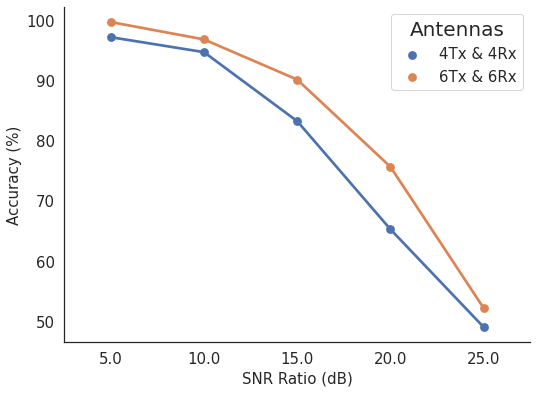

In [75]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
data = []
dBs = [5, 10, 15, 20, 25]
A_4 = [97.17, 94.69, 83.25, 65.33, 49.12]
A_6 = [99.68, 96.80, 90.14, 75.69, 52.28]
data.append(dBs)
data.append(A_4)
data.append(A_6)
data = np.transpose(np.array(data))
df = pd.DataFrame(data, columns=['dB', '4Tx & 4Rx', '6Tx & 6Rx'])
df_melted = df.melt('dB', var_name='Antennas', value_name='Acc')
df_melted.head()

plt.rc('xtick', labelsize=15)    # fontsize of the tick labels
plt.rc('ytick', labelsize=15)    # fontsize of the tick labels
sns.catplot(data=df_melted, x='dB', y='Acc', hue='Antennas', kind='point', height=8, aspect=10/8, legend=False)
#sns.set_style('white')
plt.xlabel('SNR Ratio (dB)', fontsize=15)
plt.ylabel('Accuracy (%)', fontsize=15)
#plt.title('Accuracy (%) in diffrent SNR ratio (dB)', fontsize=20)
plt.legend(fontsize=15, title='Antennas', title_fontsize=20)
plt.show()

In [78]:
import matplotlib.pyplot as plt
import numpy as np


labels = ['Total Power', 'Idle Power', 'Dynamic Power']
GPU_power = [42, 5, 37]
Loihi_power = [1.046, 0.935, 0.111]

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

#plt.rc('xtick', labelsize=15)    # fontsize of the tick labels
#plt.rc('ytick', labelsize=15) 
fig, ax = plt.subplots()
rect1 = ax.bar(x - width/2, GPU_power, width, label='GPU')
rect2 = ax.bar(x + width/2, Loihi_power, width, label='Loihi')

plt.ylim([0, 50])

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Power Consumption (W)')
ax.set_title('Power Consumption in Different Modes')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

ax.bar_label(rect1, padding=3)
ax.bar_label(rect2, padding=3)

fig.tight_layout()

plt.show()

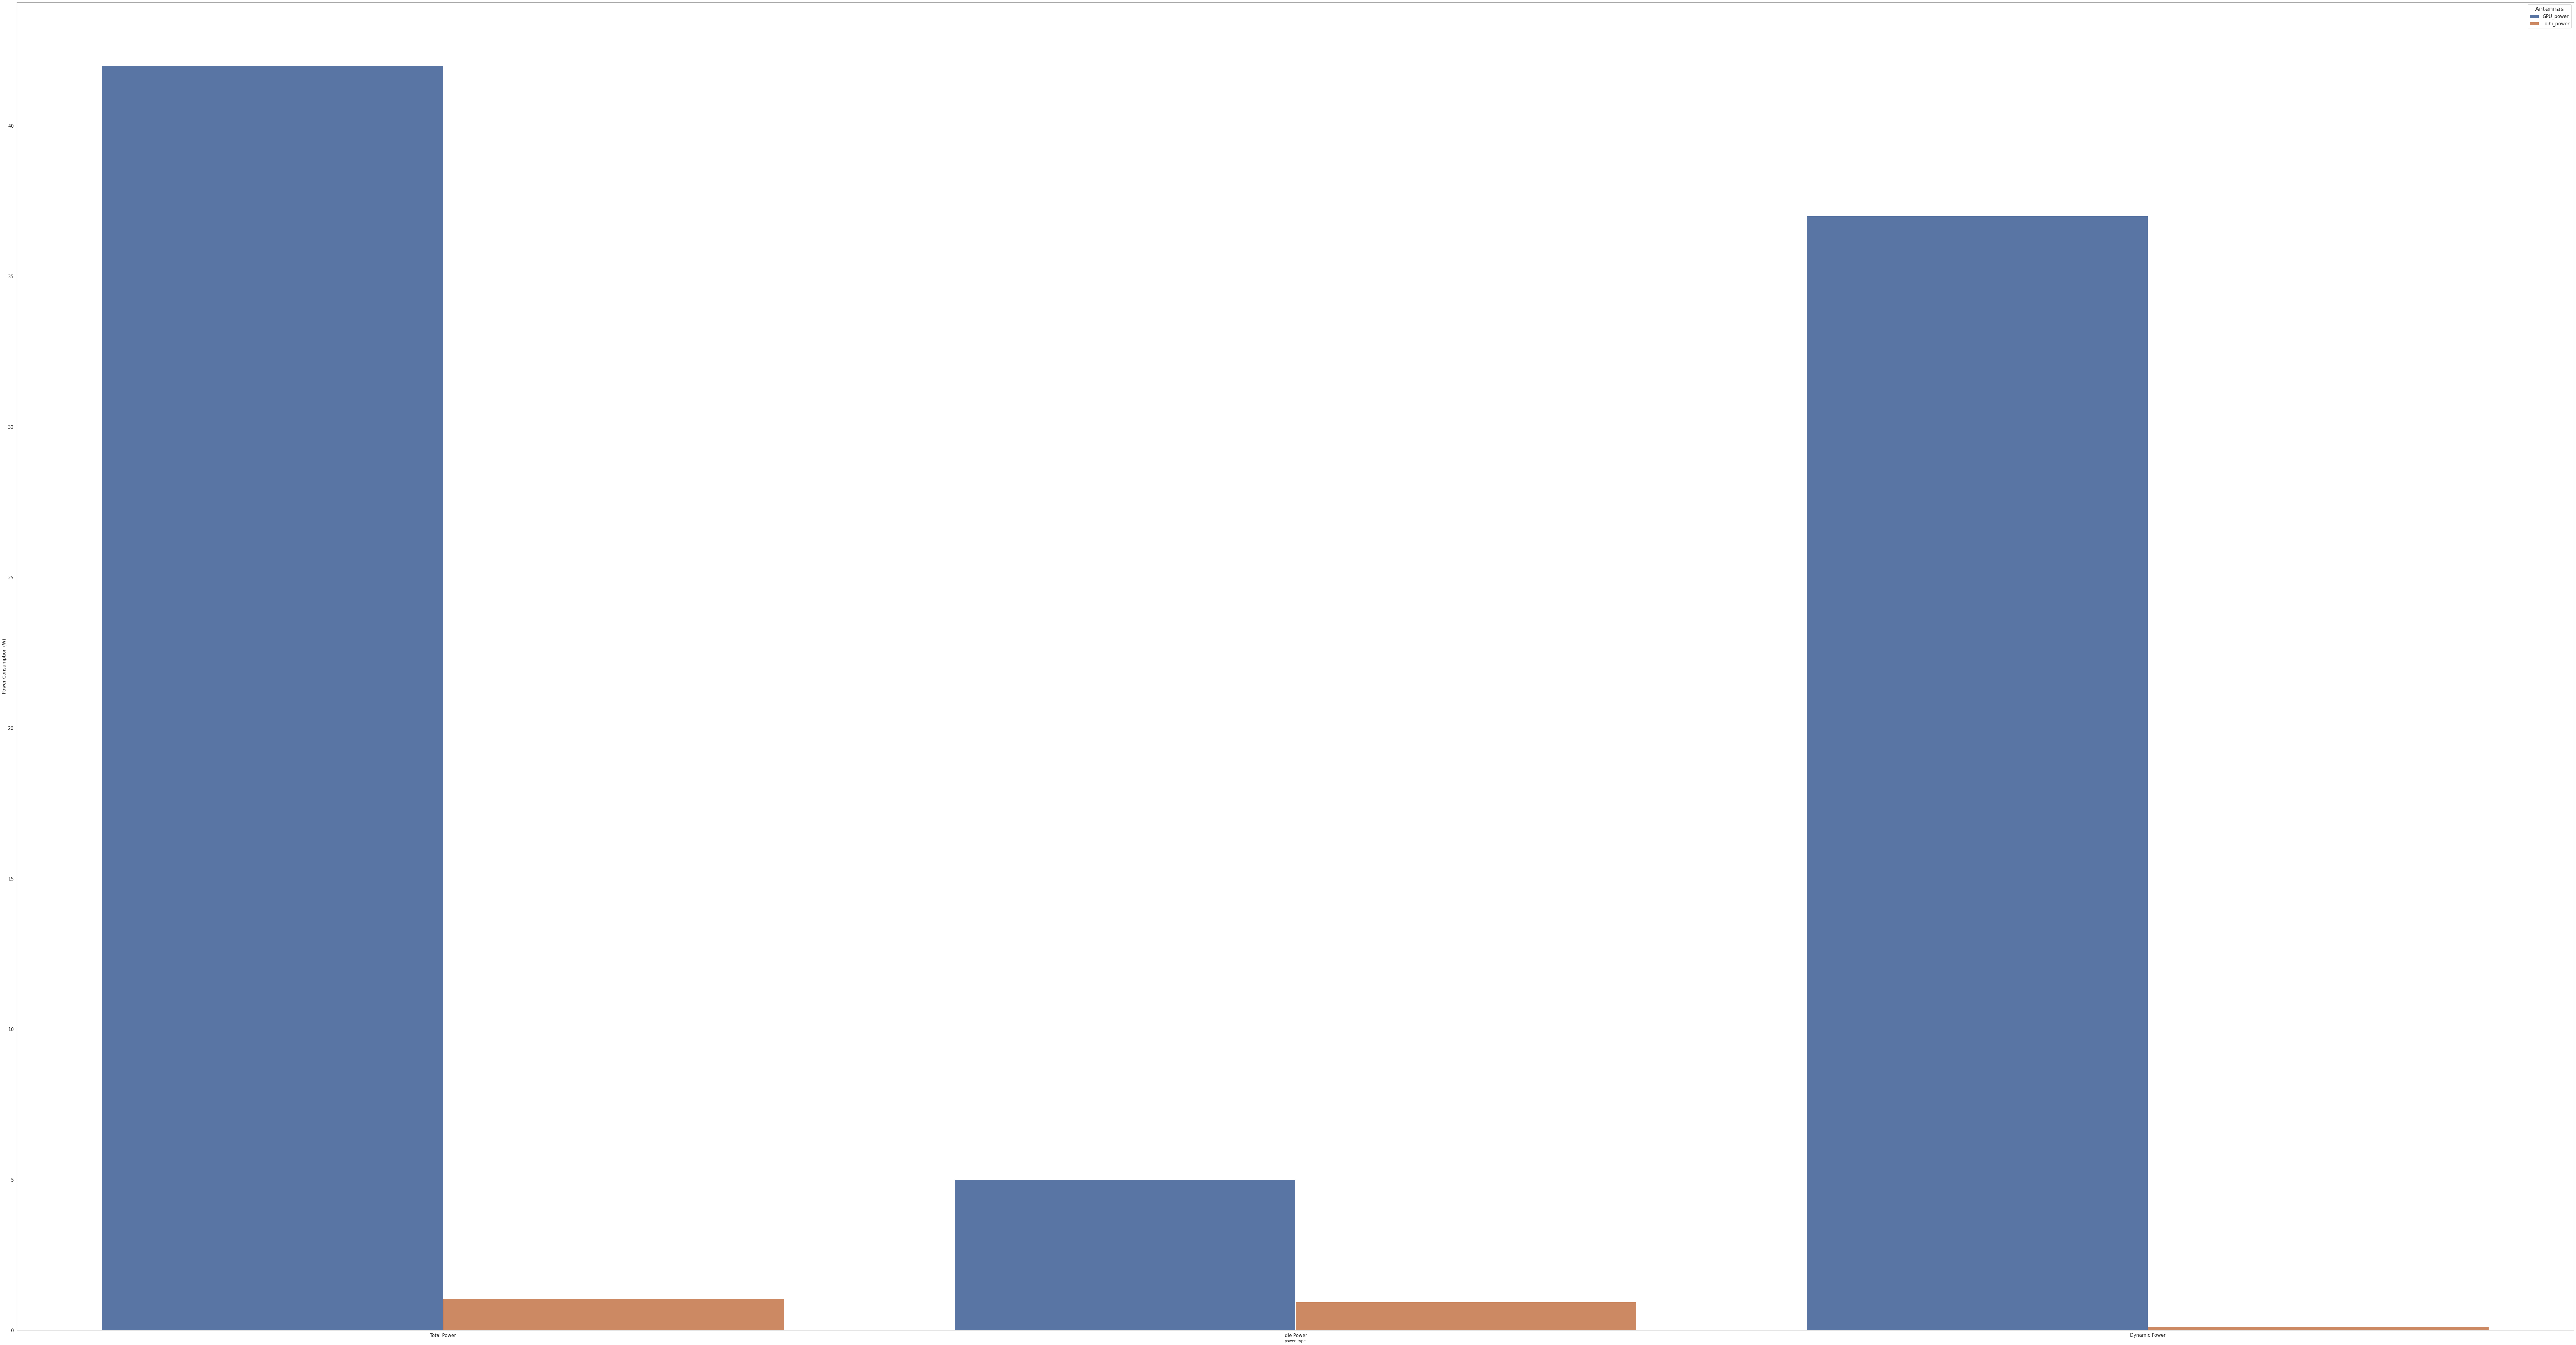

In [95]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
data = []
labels = ['Total Power', 'Idle Power', 'Dynamic Power']
GPU_power = [42, 5, 37]
Loihi_power = [1.046, 0.935, 0.111]
data.append(labels)
data.append(GPU_power)
data.append(Loihi_power)
data = np.transpose(np.array(data))
df = pd.DataFrame(data, columns=['power_type', 'GPU_power', 'Loihi_power'])
df_melted = df.melt('power_type', var_name='GPU_Loihi', value_name='consumption')
df_melted['consumption'] = df_melted['consumption'].astype('float')
df_melted.head(10)
plt.rc('xtick', labelsize=15)    # fontsize of the tick labels
plt.rc('ytick', labelsize=15)    # fontsize of the tick labels
sns.barplot(data=df_melted, x='power_type', y='consumption', hue='GPU_Loihi')
#plt.xlabel('Power Consumption (W)', fontsize=15)
plt.ylabel('Power Consumption (W)', fontsize=15)
#plt.title('Accuracy (%) in diffrent SNR ratio (dB)', fontsize=20)
plt.legend(fontsize=15, title='Antennas', title_fontsize=20)
plt.show()

AttributeError: 'BarContainer' object has no attribute 'set_color'

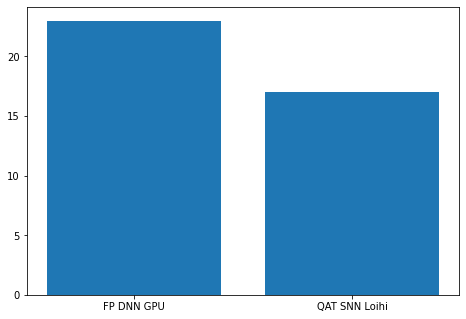

In [19]:
import matplotlib.pyplot as plt
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
langs = ['FP DNN GPU', 'QAT SNN Loihi']
students = [23,17]
rect1 = ax.bar(langs,students)
rect1.set_color('b')
ax.bar_label(rect1, padding=3)
plt.show()

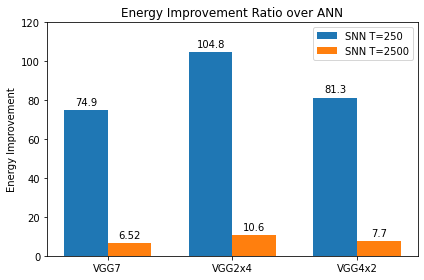

In [14]:
import matplotlib.pyplot as plt
import numpy as np


labels = ['VGG7', 'VGG2x4', 'VGG4x2']
GPU_power = [74.9, 104.8, 81.3]
Loihi_power = [6.52, 10.6, 7.7]

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rect1 = ax.bar(x - width/2, GPU_power, width, label='SNN T=250')
rect2 = ax.bar(x + width/2, Loihi_power, width, label='SNN T=2500')

plt.ylim([0, 120])

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Energy Improvement')
ax.set_title('Energy Improvement Ratio over ANN')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

ax.bar_label(rect1, padding=3)
ax.bar_label(rect2, padding=3)

fig.tight_layout()

plt.show()

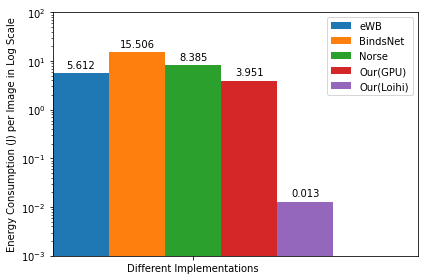

In [52]:
import matplotlib.pyplot as plt
import numpy as np


labels = ["Different Implementations"]
G1 = [5.612]
G2 = [15.506]
G3 = [8.385]
G4 = [3.951]
G5 = [0.013]
#GPU_power = [5.612, 15.506, 8.385, 3.950, 0.0129]
#Loihi_power = [0.0, 0.0, 0.0, 0.896]

x = np.arange(len(labels))  # the label locations
width = 0.2 #the width of the bars

fig, ax = plt.subplots()
rect1 = ax.bar(x - 0.4, G1, width, label='eWB')
rect2 = ax.bar(x - 0.2, G2, width, label='BindsNet')
rect3 = ax.bar(x - 0.0, G3, width, label='Norse')
rect4 = ax.bar(x + 0.2, G4, width, label='Our(GPU)')
rect5 = ax.bar(x + 0.4, G5, width, label='Our(Loihi)')

plt.ylim([0.001, 10**2])
plt.xlim([-0.5, 0.8])

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Energy Consumption (J) per Image in Log Scale')
#ax.set_title('Energe Consumption for Different Implementations (Batch size=1)')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()
ax.set_yscale('log')
ax.bar_label(rect1, padding=3)
ax.bar_label(rect2, padding=3)
ax.bar_label(rect3, padding=3)
ax.bar_label(rect4, padding=3)
ax.bar_label(rect5, padding=3)

fig.tight_layout()

plt.show()

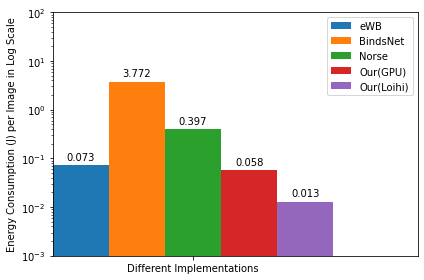

In [53]:
import matplotlib.pyplot as plt
import numpy as np


labels = ['Different Implementations']
G1 = [0.073]
G2 = [3.772]
G3 = [0.397]
G4 = [0.058]
G5 = [0.013]
#Loihi_power = [0.0, 0.0, 0.0, 0.896]

x = np.arange(len(labels))  # the label locations
width = 0.2  # the width of the bars

fig, ax = plt.subplots()
rect1 = ax.bar(x - 0.4, G1, width, label='eWB')
rect2 = ax.bar(x - 0.2, G2, width, label='BindsNet')
rect3 = ax.bar(x - 0.0, G3, width, label='Norse')
rect4 = ax.bar(x + 0.2, G4, width, label='Our(GPU)')
rect5 = ax.bar(x + 0.4, G5, width, label='Our(Loihi)')

plt.ylim([0.001, 10**2])
plt.xlim([-0.5, 0.8])

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Energy Consumption (J) per Image in Log Scale')
#ax.set_title('Energy Consumption per Image for Different Implementations (Batch size=128)')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()
ax.set_yscale('log')
ax.bar_label(rect1, padding=3)
ax.bar_label(rect2, padding=3)
ax.bar_label(rect3, padding=3)
ax.bar_label(rect4, padding=3)
ax.bar_label(rect5, padding=3)

fig.tight_layout()

plt.show()